## DATA 512: Assignment 1: Data Curation 
- Created by: Libby Montague
- Date: 10/16/2017
- The intent of this script is to pull in data from the wikipedia API and graph the page counts and views for mobile and desktop traffic. 
- The script accesses the wikipedia API (please see the liscense for more information about the liscense for the data). 
- The output of the script are json files of the original data from wikipedia, csv file of the processed data, and png of the graph. 
- Copyright 2017 Elizabeth Montague elizam8@uw.edu, under MIT License

In [1]:
# import libraries
import requests
import json
import numpy as nm
import pandas as pd
import matplotlib.pyplot as plt

### 1. Data Aquisition 
- We need to collect the following from wikipedia API:
    - Page views without spider mobile-web
    - Page views without spider mobile-app
    - Page views without spider desktop 
    - Page counts mobile
    - Page counts desktop
- The files are then written to .json files with the following structure: apiname_accesstype_firstmonth-lastmonth.json. 
- There are a couple parameters that will need to be changed so that you can run this code. You will need to set 'folder' to your working directory. You will also need to add your own 'User-Agent' and 'From' to the header clause. 

In [2]:
# code adapted from the template distributed for the class DATA 512 at UW

## set variables 
folder='{add your working directory}'
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
headers={'User-Agent' : '{add your github website}', 'From' : '{add your email address}'}
a_access=['mobile-web','mobile-app','desktop']

## collect the page views from the wikipedia API 
for i in range(0,len(a_access)): 
    # page views without spider mobile-web 
    params = {'project' : 'en.wikipedia.org',
                'access' : a_access[i],
                'agent' : 'user',
                'granularity' : 'monthly',
                'start' : '2015070100',
                'end' : '2017100100'#use the first day of the following month to ensure a full month of data is collected
                }
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    # write the result
    output=open(folder+'pageviews_'+a_access[i]+'_201507-201709.json','w')
    json.dump(response,output)
    output.close()
    
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
a_access=['mobile-site','desktop-site']

## collect the page counts from the wikipedia API
for i in range(0,len(a_access)): 
    # page views without spider mobile-web 
    params = {'project' : 'en.wikipedia.org',
                'access-site' : a_access[i],
                'granularity' : 'monthly',
                'start' : '2008010100',
                'end' : '2016080100'#use the first day of the following month to ensure a full month of data is collected
                }
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    # write the result
    output=open(folder+'pagecounts_'+a_access[i]+'_200801-201608.json','w')
    json.dump(response,output)
    output.close()

### 2. Data Processing 
- We need process the .json outputs from the wikipedia API to count the page views. 
- I started by reading in the .json files and keeping the relevant data in a numpy array. 

In [3]:
## set an iterator
i=0
## store the names of the files 
files=['pagecounts_desktop-site_200801-201608.json','pageviews_mobile-app_201507-201709.json',
       'pagecounts_mobile-site_200801-201608.json','pageviews_mobile-web_201507-201709.json',
       'pageviews_desktop_201507-201709.json']
## set the name of the access type 
a='access'
for f in files:
    # read in the files 
    read=open(folder+f,'r')
    data_json=json.load(read)['items']
    # process the files 
    for row in data_json:
        ## check if this is 'count' data, set the access type to 'access-site' 
        if f[4:9] == 'count': a='access-site'
        ## get the relevant information from the json data type 
        new_row=[row['timestamp'][:6],row[f[4:9]],row[a]+'-'+f[4:9]]
        ## check if this is the first data entry 
        if i == 0:
            ## create a result 
            result=new_row
        else:
            ## add to the result 
            result=nm.vstack((result,new_row))
        ## iterate through 
        i=i+1
    ## set the access type back to 'access' 
    a='access'

- Next I reshaped the data and created the correct columns in the correct order. 
- Finally I wrote the resulting data table to a .csv in the same working directory. 

In [4]:
## reshape the data 
result_pivot=pd.DataFrame(result).pivot(index=0,columns=2,values=1)
# replace all 'None' with 0
result_pivot=result_pivot.fillna(0)
## create the correct columns 
result_pivot['pagecount_all_views']=pd.to_numeric(result_pivot['desktop-site-count'])+pd.to_numeric(result_pivot['mobile-site-count'])
result_pivot['pageview_mobile_views']=pd.to_numeric(result_pivot['mobile-web-views'])+pd.to_numeric(result_pivot['mobile-app-views'])
result_pivot['pageview_all_views']=pd.to_numeric(result_pivot['desktop-views'])+pd.to_numeric(result_pivot['pageview_mobile_views'])
result_pivot['pagecount_desktop_views']=pd.to_numeric(result_pivot['desktop-site-count'])
result_pivot['pageview_desktop_views']=pd.to_numeric(result_pivot['desktop-views'])
result_pivot['pagecount_mobile_views']=pd.to_numeric(result_pivot['mobile-site-count'])
## create the year and month column 
result_pivot['year']=result_pivot.index.str.slice(0,4)
result_pivot['month']=result_pivot.index.str.slice(4,6)
## reorder and keep only the relevant columns 
result_pivot=result_pivot[['year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views',
                           'pageview_all_views','pageview_desktop_views','pageview_mobile_views']]
## write to a file 
result_pivot.to_csv(folder+'en-wikipedia_traffic_200801-201709.csv',index=False)

### 3. Analysis 
- In this step, I plot the page views and counts over time. 
- The resulting figure is saved to a file (wikipedia_pageviews_en_2008_2017.png) in the working directory. 

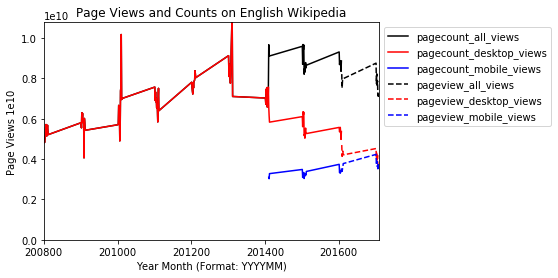

In [13]:
## plot within the jupyter notebook
%matplotlib inline
## find the max y value
ymax=max(nm.hstack((result_pivot['pagecount_all_views'],result_pivot['pagecount_desktop_views'],
                   result_pivot['pagecount_mobile_views'],result_pivot['pageview_all_views'],
                   result_pivot['pageview_desktop_views'],result_pivot['pageview_mobile_views'])))
## set the x and y limit
plt.axis([min(pd.to_numeric(result_pivot.index)),max(pd.to_numeric(result_pivot.index)),0,ymax])
## plot the page counts 
plt.plot(result_pivot.index[:103],result_pivot['pagecount_all_views'][:103],'k-')
plt.plot(result_pivot.index[:103],result_pivot['pagecount_desktop_views'][:103],'r-')
plt.plot(result_pivot.index[81:103],result_pivot['pagecount_mobile_views'][81:103],'b-')
## plot the page views
## use the '[]--' to indicate a dashed line and the color  
plt.plot(result_pivot.index[103:],result_pivot['pageview_all_views'][103:],'k--')
plt.plot(result_pivot.index[103:],result_pivot['pageview_desktop_views'][103:],'r--')
plt.plot(result_pivot.index[103:],result_pivot['pageview_mobile_views'][103:],'b--')
## add labels
plt.xlabel('Year Month (Format: YYYYMM)')  
plt.ylabel('Page Views 1e10')  
plt.title('Page Views and Counts on English Wikipedia')  
## add a legend
plt.legend(loc=0,bbox_to_anchor=(1,1))
## save to a file
## use bbox_inches to include the legend
plt.savefig(folder+'wikipedia_pageviews_en_2008_2017.png',bbox_inches='tight')